In [1]:
# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.
import pandas as pd
pd.options.display.float_format ='{:20,.2f}'.format

from project_lib import Project
project = Project.access()
DWH_AI_Test_credentials = project.get_connection(name="DWH_AI_Test")

import pandas as pd, cx_Oracle
import numpy as np
from datetime import datetime 
DWH_AI_Test_dsn = cx_Oracle.makedsn(host = DWH_AI_Test_credentials['host'], port = DWH_AI_Test_credentials['port'], sid = DWH_AI_Test_credentials['sid'])
DWH_AI_Test_connection = cx_Oracle.connect(DWH_AI_Test_credentials['username'], DWH_AI_Test_credentials['password'], DWH_AI_Test_dsn, encoding = 'UTF-8', nencoding = 'UTF-8')


query = 'SELECT * FROM DWH_ATOMIC.DIM_CUSTOMER where rownum < 10'
cursor = DWH_AI_Test_connection.cursor()

cursor.execute(query)
query_data = cursor.fetchall()

col_names = [colname[0] for colname in cursor.description]
data_df_1 = pd.DataFrame(data=query_data, columns=col_names)
data_df_1.head()


# You can close the database connection with the following code.
# DWH_AI_Test_connection.close()
# To learn more about the cx_Oracle package, please read the documentation: https://pypi.org/project/cx-Oracle/

,N_CUST_SKEY,FIC_MIS_DATE,V_D_CUST_REF_CODE,V_D_CUST_MIS_CLASS3,V_D_CUST_MIS_CLASS4,V_D_CUST_MIS_CLASS5,V_D_CUST_MIS_CLASS6,V_D_CUST_MIS_CLASS7,V_D_CUST_MIS_CLASS8,V_D_CUST_MIS_CLASS9,...,WRT_OFF_AMT,REAL_USR_FLG,RGSTR_GOV_FLG,CMRCL_RGSTR_NMBR,MOB_OWNR_FLG,TAX_PAY_CD,TAX_PAY_CTRY_CD,EXT_ENTR_EXP_DT,VAT_RGSTR_FLG,VAT_RGSTR_MNTN_DT
0,170674916,2021-08-03,5499411,None,None,None,None,None,None,None,...,None,Y,Y,None,Y,None,None,None,None,NaT
1,891059012,2022-06-10,4222258,None,None,None,None,None,None,None,...,None,Y,Y,None,Y,None,None,None,None,NaT
2,903108363,2022-11-14,6398521,None,None,None,None,None,None,None,...,None,None,None,None,Y,None,None,None,None,NaT
3,900684736,2022-10-17,4035660,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,NaT
4,862855523,2021-12-06,3255375,None,None,None,None,None,None,None,...,None,None,None,None,None,None,SA,None,None,NaT


In [2]:
cust_population_table = "DWH_AI.MICRO_SEG_POPULATION_PROD"
cust_training_accbal1     = "DWH_AI.micro_seg_accbal_1_prod"
cust_training_accbal2     = "DWH_AI.CHURN_TMP_TRAINING_ACC_BAL_02_prod"
seg_init_temp_table = "DWH_AI.SEG_init_RESULTS_T1_temp"
seg_2_result =  "DWH_AI.seg_2_results_staging_PROD"


final_segment_table_d1 =  "DWH_AI.seg_1_results_wr_PROD" 
final_segment_table_d2 = "DWH_AI.seg_2_final_results_PROD"
final_segment_table_d3 = "DWH_AI.seg_3_final_results_PROD"
micro_cluster_table = "DWH_AI.micro_cluster_results"
def execute(query):
    # This function gets dataframe with query
    cursor = DWH_AI_Test_connection.cursor()
    cursor.execute(query)
    query_data = cursor.fetchall()
    return pd.DataFrame(data=query_data, columns=[colname[0] for colname in cursor.description])

def reset_table(table_name):
    cursor = DWH_AI_Test_connection.cursor()
    cursor.execute(f"""
    BEGIN
        EXECUTE IMMEDIATE 'TRUNCATE TABLE {table_name}';
    EXCEPTION
        WHEN OTHERS THEN
            IF SQLCODE != -942 THEN
                RAISE;
            END IF;
    END;
    """)
    cursor.execute(f"""
    BEGIN
        EXECUTE IMMEDIATE 'DROP TABLE {table_name}';
    EXCEPTION
        WHEN OTHERS THEN
            IF SQLCODE != -942 THEN
                RAISE;
            END IF;
    END;
    """)

def insert_into(table_name, df):
    # insert pandas dataframe into database
    # if data is very huge, you can insert with chunks
    cursor = DWH_AI_Test_connection.cursor()

    sql = 'INSERT INTO '+ table_name +' VALUES('
    for idx,column in enumerate(df.columns):
        sql += ':'+str(idx+1)+','
    sql = sql[:-1] + ')'

    df_values = df.values
    cols = []
    for i in range(0,len(df)):
        cols.append(tuple(df_values[i]))

    cursor.executemany(sql,cols)
    DWH_AI_Test_connection.commit()
    cursor.close()     

In [24]:
## mapping table
## dimension names(mappings) are given here, changes should be done here!
cluster_codes = ["d1_1", "d1_2", "d1_3", "d2_1", "d2_2", "d2_3", "d2_4", "d2_5", "d2_6", "d2_7", "d3_1", "d3_2", "d3_3", "d3_4", "d3_5"]
mapping = [" midage_scholarly_highincome", "midage_leastscholarly_lowincome", "younger_midscholarly_lowincome",
           
           "inactive_value", "only_lapplicant", 
           "less_active_value", "pl_ori" , 
           "rl_ori", " current_ac_ori" , "saving_ori",
           "less_engaged", "freq_app_user", "app_transferer", "loan_delayer", "cc_delayer"
          ]
print(len(cluster_codes))
print(len(mapping))
df_map= pd.DataFrame(cluster_codes, columns=["cluster_codes"])
df_map["mapping"] = mapping
df_map

15
15


,cluster_codes,mapping
0,d1_1,midage_scholarly_highincome
1,d1_2,midage_leastscholarly_lowincome
2,d1_3,younger_midscholarly_lowincome
3,d2_1,inactive_value
4,d2_2,only_lapplicant
5,d2_3,less_active_value
6,d2_4,pl_ori
7,d2_5,rl_ori
8,d2_6,current_ac_ori
9,d2_7,saving_ori


In [25]:
import time
df_map = df_map
df_map_table_name =  "DWH_AI.micro_seg_mappings"
reset_table(df_map_table_name)
try:
    # if sql gives an error, there is no table named cust_segments_results
    _ = pd.read_sql(f'SELECT * FROM {df_map_table_name} where rownum < 2', con = DWH_AI_Test_connection)
except:
    q = f"""
    CREATE TABLE {df_map_table_name} (
        cluster_codes VARCHAR2(50),
        mapping VARCHAR2(150)
        
    )
    """
    cursor.execute(q)
    DWH_AI_Test_connection.commit()
    print(datetime.now(), "-> mappings  Table is created or truncated.")
    time.sleep(5)
finally:
    cursor = DWH_AI_Test_connection.cursor()
    cursor.execute(f'TRUNCATE TABLE {df_map_table_name}')
    

    
    insert_into(df_map_table_name, df_map)
    print(datetime.now(), "->  mappings  Table is filled.")
   

2022-12-15 11:30:11.993844 -> mappings  Table is created or truncated.
2022-12-15 11:30:17.208919 ->  mappings  Table is filled.


## CREATING FINAL OUTPUT TABLE

In [26]:
final_segment_table_d1 =  "DWH_AI.seg_1_results_wr_PROD" 
final_segment_table_d2 = "DWH_AI.seg_2_final_results_PROD"
final_segment_table_d3 = "DWH_AI.seg_3_final_results_PROD"
micro_cluster_table = "DWH_AI.micro_cluster_results" # final table
mapping_table = "DWH_AI.micro_seg_mappings"

reset_table(micro_cluster_table)

query=f"""
CREATE TABLE {micro_cluster_table} as 

select t1.CIF_KEY, t1.AS_OF_DATE, t1.clusters dim1_cluster, m1.mapping as dim1_mapping, 
t2.clusters_f dim2_cluster, m2.mapping as dim2_mapping,
t3.clusters as dim3_cluster, m3.mapping as dim3_mapping,
T1.clusters || '-' || t2.clusters_f || '-' || t3.clusters as micro_cluster,
 m1.mapping || ' -&- ' || m2.mapping || ' -&- ' || m3.mapping as micro_cluster_mapping
---substr(T1.clusters, -1, 1)  || substr(T2.clusters_f, -1, 1) || substr(T3.clusters, -1, 1) micro_cluster

from {final_segment_table_d1} t1
inner join {final_segment_table_d2} t2 on t1.CIF_KEY = t2.CIF_KEY
left join {final_segment_table_d3} t3 on t1.CIF_KEY = t3.CIF_KEY  --there are not dim3 segments for d2_1, d2_2 

left join {mapping_table} m1 on m1.cluster_codes = t1.clusters
left join {mapping_table} m2 on m2.cluster_codes = t2.clusters_f
left join {mapping_table} m3 on m3.cluster_codes = t3.clusters


"""
cursor.execute(query)
print("micro segmentation table  is created at:", datetime.now())
print(f"table name : {micro_cluster_table}")

micro segmentation table  is created at: 2022-12-15 11:30:35.905527
table name : DWH_AI.micro_cluster_results


In [17]:
d1=execute("select * from micro_cluster_results WHERE dim1_cluster ='d1_1' and dim2_cluster ='d2_6' and dim3_cluster ='d3_3'  ")
d1

,CIF_KEY,AS_OF_DATE,DIM1_CLUSTER,DIM1_MAPPING,DIM2_CLUSTER,DIM2_MAPPING,DIM3_CLUSTER,DIM3_MAPPING,MICRO_CLUSTER,MICRO_CLUSTER_MAPPING
0,2570584,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
1,486019,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
2,4119518,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
3,165929,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
4,1713791,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
...,...,...,...,...,...,...,...,...,...,...
5494,482786,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
5495,1455325,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
5496,1395315,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...
5497,775558,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_6,current_ac_ori,d3_3,app_transferer,d1_1-d2_6-d3_3,midage_scholarly_highincome -&- current_ac_o...


In [20]:
d1=execute("select * from micro_cluster_results WHERE dim1_cluster ='d1_3' and dim2_cluster ='d2_4' and dim3_cluster ='d3_4'  ")
d1

,CIF_KEY,AS_OF_DATE,DIM1_CLUSTER,DIM1_MAPPING,DIM2_CLUSTER,DIM2_MAPPING,DIM3_CLUSTER,DIM3_MAPPING,MICRO_CLUSTER,MICRO_CLUSTER_MAPPING
0,3826287,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
1,3923229,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
2,3925845,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
3,3937110,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
4,3899302,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
...,...,...,...,...,...,...,...,...,...,...
251,3744577,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
252,3884351,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
253,2452233,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...
254,2926253,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_4,pl_ori,d3_4,loan_delayer,d1_3-d2_4-d3_4,younger_midscholarly_lowincome -&- pl_ori -&- ...


## Backup Segmentation Table ##

In [ ]:
#final result table stored in database 
today_= datetime.now().strftime("%m_%y")

query="""
CREATE TABLE MICRO_CLUSTERS_BACKUP_"""+ str(today_) +"""_ as
select * from micro_cluster_results """

cursor = DWH_AI_Test_connection.cursor()

cursor.execute(query)
table_name = """MICRO_CLUSTERS_BACKUP_"""+ str(today_) +"""_ """
print(f"backup table created as : {table_name} ")

## Final Table with the features

In [27]:
reset_table("TMP_MC_RESULTS_FEATURES")

In [28]:
## this table can use for analsing the segments summary statistics!!
    
    
execute("""---CREATE GLOBAL TEMPORARY TABLE TMP_MC_RESULTS_FEATURES ON COMMIT PRESERVE ROWS
CREATE TABLE TMP_MC_RESULTS_FEATURES
AS

SELECT T1.*,

 N_D_CUST_AGE_ON_BOOK  AS AGE,
  T2.V_D_CUST_SEGMENT  AS ALINMA_SEGMENT,
  V_D_CUST_EDUCATION  AS EDUCATION,
  V_D_CUST_JOB_TITLE  AS JOB_TITLE,
  V_D_CUST_CITY  AS CITY,
  REGION  AS REGION,
  V_D_CUST_NATIONALITY_CTRY_CODE  AS NATIONALITY,
  V_CUST_EMPLOYMENT_TYPE_CODE  AS EMPLOYMENT_TYPE,
  V_D_CUST_GENDER  AS GENDER,
  V_MARITAL_STATUS_CD  AS MARITAL_STATUS,
  CUST_ANNUAL_INCOME  AS INCOME,
  TENURE  AS TENURE,

  MONETARY_MONEY_TRANSFERS_L1Y,
  NB_OF_MONEY_TRANSFERS,
  MAX_BALANCE_T38 ,
  MAX_BALANCE_T37 ,
  AVG_BALANCE_T32 ,
  AVG_BALANCE_T35 ,
  NUMBER_OF_LOANS_T314_17 ,
  TOTAL_FUNDING_AMOUNT_T314_17 ,
  NUMBER_OF_LOANS_T313_15_16 ,
  TOTAL_FUNDING_AMOUNT_T313_15_16 ,
  NUMBER_OF_APPLICATIONS ,
 
  DELINQUENT_LOAN_INS_L5Y ,
  DELINQUENT_CC_INS_L5Y ,
  MOBILE_APP_LOGIN_L1Y ,
  MOBILE_APP_LOGIN_L3M ,
  DAYS_USING_ATM_L3M ,
  BRANCH_VISITS_L3M ,
  NUMBER_OF_ENGAGED_CAMPAIGN ,
  MOBILE_TRNS_COUNT_L3M ,
  MOBILE_TRNS_AMNT_L3M ,
  ATM_TRNS_AMNT_L3M ,
  CHURN_PRED_SCORE ,
  T5.V_D_CUST_SEGMENT
  
  
FROM micro_cluster_results T1
INNER JOIN (select CIF_KEY CIF_KEY_1, AS_OF_DATE AS_OF_DATE_1,  A.* FROM MICRO_SEGMENTATION_FEAT_D1_PROD A) T2 ON T2.CIF_KEY=T1.CIF_KEY
INNER JOIN (SELECT CIF_KEY AS CIF_KEY_2, AS_OF_DATE  AS_OF_DATE_2, A.* FROM  MICRO_SEGMENTATION_FEAT_D2_PROD A) T3 ON T3.CIF_KEY=T1.CIF_KEY
INNER JOIN (SELECT CIF_KEY AS CIF_KEY_3, AS_OF_DATE AS_OF_DATE_3, A.*  FROM MICRO_SEGMENTATION_FEAT_D3_PROD A) T4 ON T4.CIF_KEY=T1.CIF_KEY
LEFT JOIN ( SELECT CIF_KEY, V_D_CUST_SEGMENT   from DWH_ATOMIC.DIM_CUSTOMER  t2    where t2.F_LATEST_RECORD_INDICATOR = 'Y') T5 ON T5.CIF_KEY = T1.CIF_KEY


""")

InterfaceError: not a query

In [23]:
execute("select * from DWH_AI.TMP_MC_RESULTS_FEATURES where rownum < 10")

,CIF_KEY,AS_OF_DATE,DIM1_CLUSTER,DIM1_MAPPING,DIM2_CLUSTER,DIM2_MAPPING,DIM3_CLUSTER,DIM3_MAPPING,MICRO_CLUSTER,MICRO_CLUSTER_MAPPING,...,MOBILE_APP_LOGIN_L1Y,MOBILE_APP_LOGIN_L3M,DAYS_USING_ATM_L3M,BRANCH_VISITS_L3M,NUMBER_OF_ENGAGED_CAMPAIGN,MOBILE_TRNS_COUNT_L3M,MOBILE_TRNS_AMNT_L3M,ATM_TRNS_AMNT_L3M,CHURN_PRED_SCORE,V_D_CUST_SEGMENT
0,2568711,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_3,less_active_value,d3_1,less_engaged,d1_1-d2_3-d3_1,midage_scholarly_highincome -&- less_active_v...,...,4,0,0,0,0,8,"16,427.04",0.00,0,Alinma Classic
1,3380079,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_3-d2_3-d3_1,younger_midscholarly_lowincome -&- less_active...,...,26,0,0,0,0,0,0.00,166.67,0,Digital
2,3941725,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_3-d2_3-d3_1,younger_midscholarly_lowincome -&- less_active...,...,3,1,0,0,0,0,0.00,16.67,0,Digital
3,10296,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_3,less_active_value,d3_1,less_engaged,d1_1-d2_3-d3_1,midage_scholarly_highincome -&- less_active_v...,...,18,0,0,6,0,5,"23,500.00",0.00,0,Alinma Classic
4,2323309,2022-10-31 11:02:39,d1_1,midage_scholarly_highincome,d2_3,less_active_value,d3_1,less_engaged,d1_1-d2_3-d3_1,midage_scholarly_highincome -&- less_active_v...,...,84,11,0,0,0,2,"1,172.00",0.00,0,Alinma Gold
5,4066216,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_3-d2_3-d3_1,younger_midscholarly_lowincome -&- less_active...,...,21,0,0,0,0,0,0.00,0.00,0,Digital
6,932489,2022-10-31 11:02:39,d1_2,midage_leastscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_2-d2_3-d3_1,midage_leastscholarly_lowincome -&- less_activ...,...,60,0,0,0,0,10,"1,805.01","2,183.33",0,Alinma Classic
7,389462,2022-10-31 11:02:39,d1_2,midage_leastscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_2-d2_3-d3_1,midage_leastscholarly_lowincome -&- less_activ...,...,13,3,0,0,0,8,"12,360.00",0.00,0,Alinma Gold
8,3522389,2022-10-31 11:02:39,d1_3,younger_midscholarly_lowincome,d2_3,less_active_value,d3_1,less_engaged,d1_3-d2_3-d3_1,younger_midscholarly_lowincome -&- less_active...,...,0,0,0,0,0,0,0.00,"5,100.00",0,Alinma Gold


## Creatig  Additional Visiualisations

In [326]:
df_an1=execute("""
select 
MICRO_CLUSTER,
MICRO_CLUSTER_MAPPING, 
count(*) as cnt,
avg(AGE), median(Age),
avg(TENURE), median(TENURE),
sum(case when education = 1 then 1 else 0 end ) / count(*) higher_edu_percentage,
avg(INCOME), median(INCOME),
sum(case when GENDER = 'Male' THEN 1 else 0 end) Male_count,
sum(case when GENDER = 'Female' THEN 1 else 0 end) Female_count,
avg(MONETARY_MONEY_TRANSFERS_L1Y) as Average_money_transfer_L1Y, median(MONETARY_MONEY_TRANSFERS_L1Y) as MEDIAN_money_transfer_L1Y,
avg(AVG_BALANCE_T35) AVG_SAVING_BAL_L1Y, median(AVG_BALANCE_T35) MEDIAN_SAVING_BAL_L1Y,
avg(AVG_BALANCE_T32) AVG_CURRENT_BAL_L1Y, median(AVG_BALANCE_T32) MEDIAN_CURRENT_BAL_L1Y,
avg(TOTAL_FUNDING_AMOUNT_T313_15_16) AVG_P_LOAN_AMNT_L1Y, median(TOTAL_FUNDING_AMOUNT_T313_15_16) MEDIAN_P_LOAN_AMNT_L1Y,  
avg(TOTAL_FUNDING_AMOUNT_T314_17) AVG_REALE_LOAN_AMNT_L5Y, median(TOTAL_FUNDING_AMOUNT_T314_17) MEDIAN_REALE_LOAN_AMNT_L5Y,  
AVG(MOBILE_TRNS_AMNT_L3M) avg_app_transaction_amount_L3M, median(MOBILE_TRNS_AMNT_L3M) median_app_transaction_amount_L3M,
avg(MOBILE_APP_LOGIN_L3M), median(MOBILE_APP_LOGIN_L3M),

SUM(CASE WHEN V_D_CUST_SEGMENT='Digital' then 1 else 0 end) ALINMA_DIGITAL_CNT,
SUM(CASE WHEN  V_D_CUST_SEGMENT='Alinma Classic' then 1 else 0 end) ALINMA_Classic_CNT,
SUM(CASE WHEN V_D_CUST_SEGMENT='Alinma Gold' then 1 else 0 end) ALINMA_GOLD_CNT,
SUM(CASE WHEN V_D_CUST_SEGMENT='Alinma Diamond' then 1 else 0 end) ALINMA_DIAMOND_CNT



from TMP_MC_RESULTS_FEATURES
group by MICRO_CLUSTER, MICRO_CLUSTER_MAPPING
order by  cnt desc

""")



In [328]:
df_an1.head()

,MICRO_CLUSTER,MICRO_CLUSTER_MAPPING,CNT,AVG(AGE),MEDIAN(AGE),AVG(TENURE),MEDIAN(TENURE),HIGHER_EDU_PERCENTAGE,AVG(INCOME),MEDIAN(INCOME),...,AVG_REALE_LOAN_AMNT_L5Y,MEDIAN_REALE_LOAN_AMNT_L5Y,AVG_APP_TRANSACTION_AMOUNT_L3M,MEDIAN_APP_TRANSACTION_AMOUNT_L3M,AVG(MOBILE_APP_LOGIN_L3M),MEDIAN(MOBILE_APP_LOGIN_L3M),ALINMA_DIGITAL_CNT,ALINMA_CLASSIC_CNT,ALINMA_GOLD_CNT,ALINMA_DIAMOND_CNT
0,d1_2-d2_1-,midage_leastscholarly_lowincome -&- inactive_v...,719214,40.86,38.00,88.06,87.00,0.00,"41,495.27",13200,...,1.50,0.00,27.92,0.00,0.02,0.00,1094,708026,9572,71
1,d1_3-d2_3-d3_1,younger_midscholarly_lowincome -&- less_active...,632597,28.96,28.00,21.82,16.00,0.14,"345,073,248.94",19200,...,12.51,0.00,"3,129.89",0.00,4.00,0.00,249941,373265,9107,21
2,d1_3-d2_1-,younger_midscholarly_lowincome -&- inactive_va...,581295,31.36,30.00,22.40,17.00,0.15,"62,812.82",24000,...,1.65,0.00,182.42,0.00,0.22,0.00,342747,237656,764,33
3,d1_2-d2_3-d3_1,midage_leastscholarly_lowincome -&- less_activ...,485561,40.13,38.00,78.81,79.00,0.00,"112,010.01",24000,...,89.33,0.00,"4,813.02",0.00,4.12,0.00,522,351823,131223,351
4,d1_1-d2_3-d3_1,midage_scholarly_highincome -&- less_active_v...,400584,37.62,36.00,62.21,56.00,0.96,"452,021.02",72000,...,185.10,0.00,"9,203.84",420.00,5.30,1.00,24748,242281,129661,1279


In [257]:
import matplotlib.pyplot as plt
#cl1="d1_1-d2_6-d3_1" ##
#cl0= "d1_3-d2_4-d3_1"

cl1="d1_3-d2_3-d3_2"
cl0 ="d1_1-d2_7-d3_3"

df_p1= df_an1.query("MICRO_CLUSTER == @cl1 or MICRO_CLUSTER ==@cl2 or  MICRO_CLUSTER ==@cl3 or MICRO_CLUSTER ==@cl4 or MICRO_CLUSTER ==@cl5 ")[["MICRO_CLUSTER", "MICRO_CLUSTER_MAPPING","CNT","AVG(AGE)",
                                                                                                "AVG(INCOME)", "HIGHER_EDU_PERCENTAGE", ]]
df_an1.query("MICRO_CLUSTER == @cl2 or MICRO_CLUSTER ==@cl3")

#fig = plt.figure(figsize=(10,5))
#plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[""] )

,MICRO_CLUSTER,MICRO_CLUSTER_MAPPING,CNT,AVG(AGE),MEDIAN(AGE),AVG(TENURE),MEDIAN(TENURE),HIGHER_EDU_PERCENTAGE,AVG(INCOME),MEDIAN(INCOME),...,AVG_CURRENT,MEDIAN_CURRENT,AVG(TOTAL_FUNDING_AMOUNT_T313_15_16),MEDIAN(TOTAL_FUNDING_AMOUNT_T313_15_16),AVG(TOTAL_FUNDING_AMOUNT_T314_17),MEDIAN(TOTAL_FUNDING_AMOUNT_T314_17),ALINMA_DIGITAL_PERC,ALINMA_CLASSIC_PERC,ALINMA_GOLD_PERC,ALINMA_DIAMOND_PERC
9,d1_3-d2_3-d3_2,younger_midscholarly_lowincome -&- less_active...,47559,26.15,24.00,29.26,25.00,0.15,"35,498.75",12000,...,"1,425.11",505.95,0.00,0.00,20.15,0.00,13412,13412,1412,1
33,d1_1-d2_7-d3_3,midage_scholarly_highincome -&- saving_ori -&...,1222,44.42,42.00,85.31,86.00,0.94,"499,401.58",204000,...,"162,755.46","24,314.17","50,320.86",0.00,"59,914.83",0.00,3,3,16,1097


Text(0, 0.5, 'M.APP LOGIN COUNT')

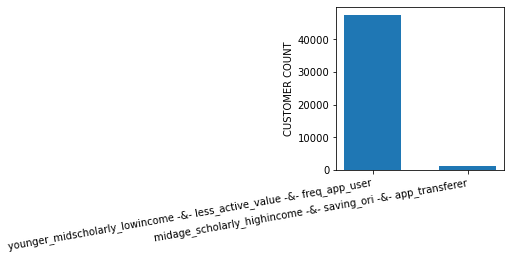

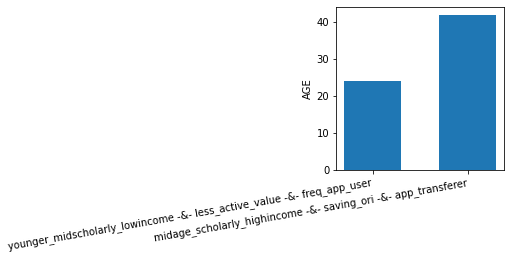

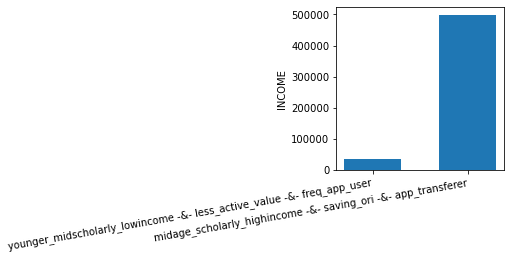

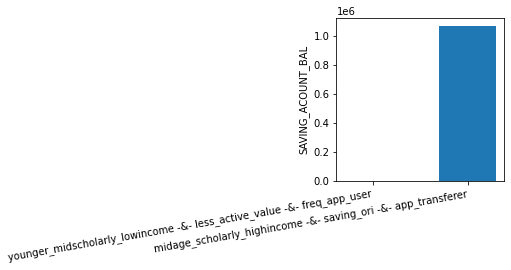

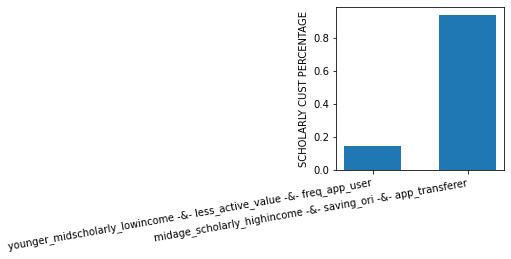

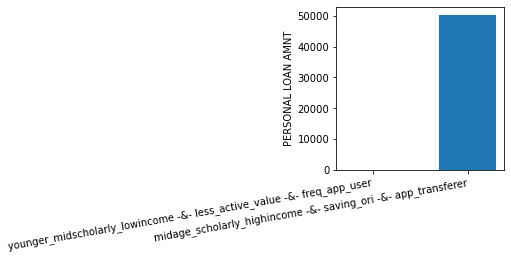

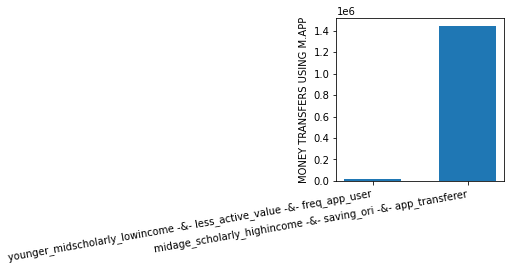

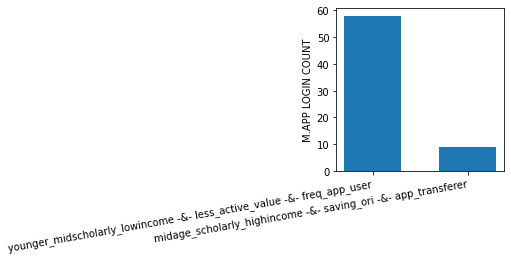

In [295]:
cl1="d1_3-d2_3-d3_2"
cl0 ="d1_1-d2_7-d3_3"
df_p1=df_an1.query("MICRO_CLUSTER == @cl1 or MICRO_CLUSTER = =@cl0")
#count
yaxis = "CNT"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')

#plt.xlabel("CLUSTERS")
plt.ylabel("CUSTOMER COUNT")


#AGE#
yaxis = "MEDIAN(AGE)"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("AGE")

#INCOME#
yaxis = "AVG(INCOME)"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("INCOME")


#saving account#
yaxis="AVG_SAVING"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("SAVING_ACOUNT_BAL")


#higher eduction
yaxis="HIGHER_EDU_PERCENTAGE"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("SCHOLARLY CUST PERCENTAGE")

#personal loan
yaxis="AVG(TOTAL_FUNDING_AMOUNT_T313_15_16)"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("PERSONAL LOAN AMNT")

##APP MONEY TRANSFER
yaxis =  "AVG_APP_TRANSACTION_AMOUNT"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("MONEY TRANSFERS USING M.APP")

##APP LOGIN
yaxis =  "MEDIAN(MOBILE_APP_LOGIN_L3M)"
fig = plt.figure(figsize=(3,3))
plt.bar(df_p1["MICRO_CLUSTER_MAPPING"], df_p1[yaxis], width = 0.6, align="center",  )
plt.xticks(rotation=10, ha='right')
#plt.xlabel("CLUSTERS")
plt.ylabel("M.APP LOGIN COUNT")


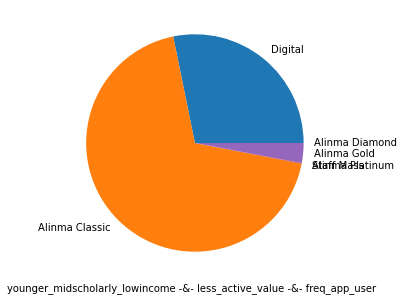

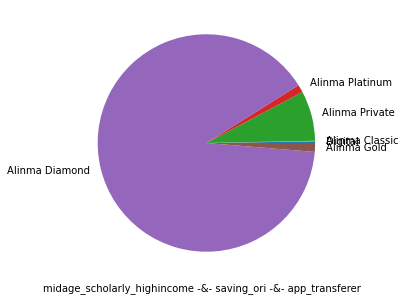

In [271]:
cl1="d1_3-d2_3-d3_2"
cl0 ="d1_1-d2_7-d3_3"


cl1_name = "younger_midscholarly_lowincome -&- less_active_value -&- freq_app_user  "


cl0_name = "midage_scholarly_highincome -&- saving_ori -&- app_transferer   "
#cl1
y=execute(f"select count(*) cnt,  V_D_CUST_SEGMENT from TMP_MC_RESULTS_FEATURES where MICRO_CLUSTER='{cl1}' group by V_D_CUST_SEGMENT")
fig = plt.figure(figsize=(5,5))
plt.pie(y["CNT"], labels=y["V_D_CUST_SEGMENT"] )
plt.xlabel(cl1_name)
plt.show()

#cl0
y=execute(f"select count(*) cnt,  V_D_CUST_SEGMENT from TMP_MC_RESULTS_FEATURES where MICRO_CLUSTER='{cl0}' group by V_D_CUST_SEGMENT")
fig = plt.figure(figsize=(5,5))
plt.pie(y["CNT"], labels=y["V_D_CUST_SEGMENT"])
plt.xlabel(cl0_name)
plt.show()




### 2. vis

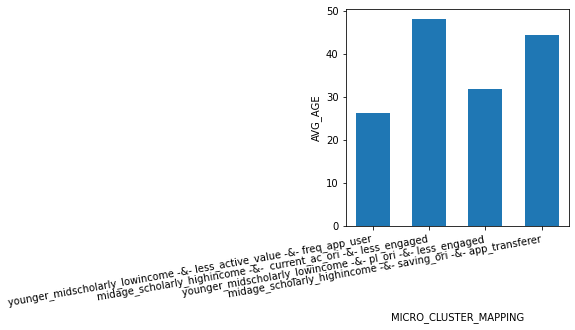

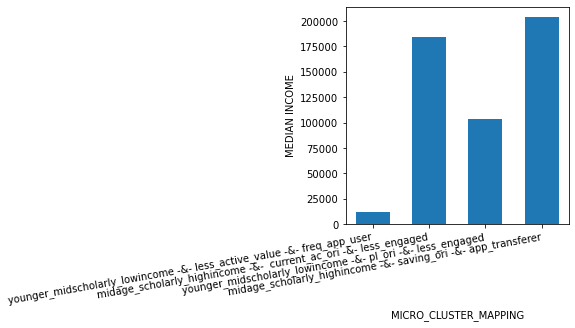

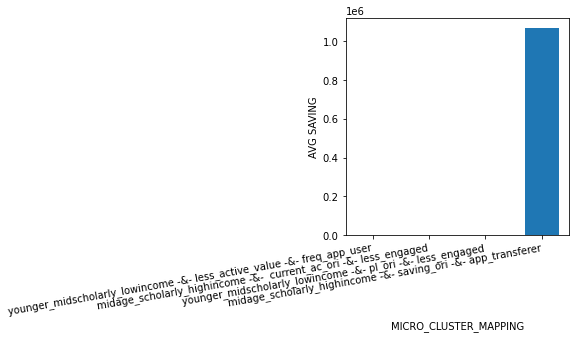

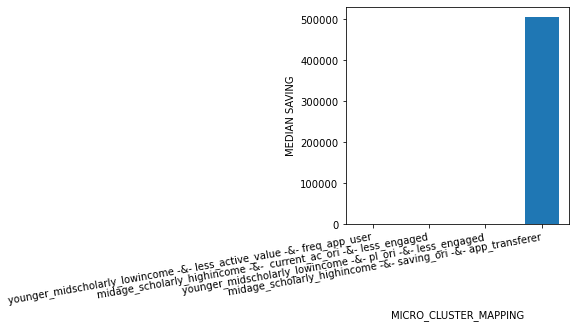

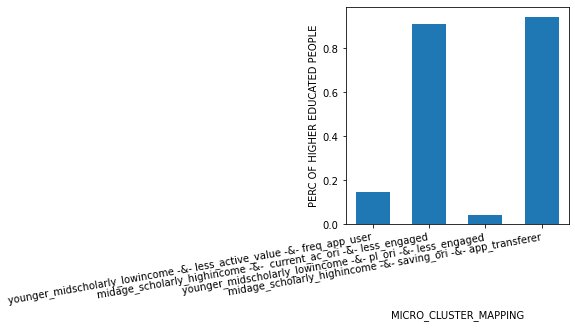

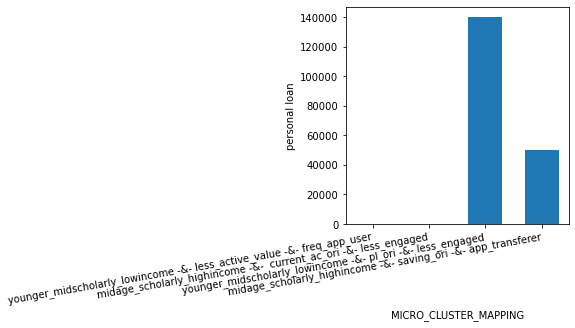

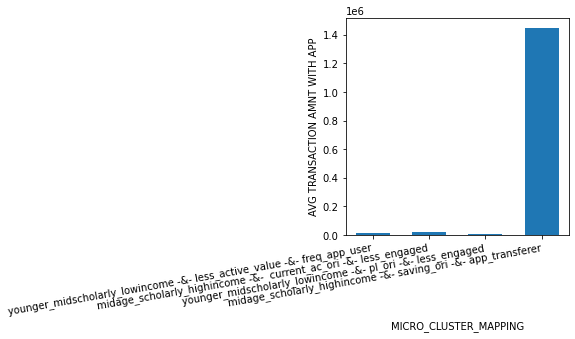

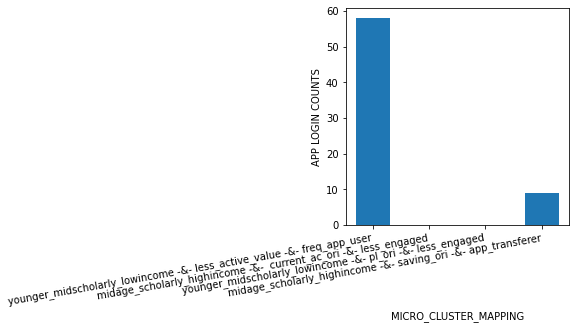

In [125]:
import matplotlib.pyplot as plt
cluster_list = ["d1_1-d2_6-d3_1","d1_3-d2_4-d3_1","d1_3-d2_3-d3_2", "d1_1-d2_7-d3_3"  ]
df_p1=df_an1.query("MICRO_CLUSTER in @cluster_list ")

def plotter(yaxis, ylabel):
    
    yaxis = yaxis
    
    xaxis= "MICRO_CLUSTER_MAPPING"
    fig = plt.figure(figsize=(4,4))
    plt.bar(df_p1[xaxis], df_p1[yaxis], width = 0.6, align="center",  )
    plt.xticks(rotation=10, ha='right')
    plt.xlabel(xaxis)
    plt.ylabel(ylabel)
    
    
plotter("AVG(AGE)", "AVG_AGE")
#plotter("AVG(INCOME)", "AVG INCOME")
plotter("MEDIAN(INCOME)", "MEDIAN INCOME")
plotter("MEDIAN_SAVING", "MEDIAN SAVING")
plotter("HIGHER_EDU_PERCENTAGE", "PERC OF HIGHER EDUCATED PEOPLE")
plotter("AVG(TOTAL_FUNDING_AMOUNT_T313_15_16)", "personal loan")
plotter("AVG_APP_TRANSACTION_AMOUNT", "AVG TRANSACTION AMNT WITH APP")
plotter("MEDIAN(MOBILE_APP_LOGIN_L3M)", "APP LOGIN COUNTS")


### Vis segmentation 3

In [221]:
def plotter(xaxis, yaxis, ylabel):
    
    
    yaxis = yaxis
    
    
    fig = plt.figure(figsize=(4,4))
    plt.bar(df_an2[xaxis], df_an2[yaxis], width = 0.6, align="center",  )
    plt.xticks(rotation=30, ha='right')
    plt.xlabel(str(xaxis) + " CLUSTERS")
    plt.ylabel(ylabel) 

In [330]:
def query_gen(DIM, DIM_MAP):
    
    an_query = f"""

select 
{DIM}, {DIM_MAP},
count(*) as cnt,
avg(AGE), median(Age),
avg(TENURE), median(TENURE),
sum(case when education = 1 then 1 else 0 end ) / count(*) higher_edu_percentage,
avg(INCOME), median(INCOME),
sum(case when GENDER = 'Male' THEN 1 else 0 end) Male_count,
sum(case when GENDER = 'Female' THEN 1 else 0 end) Female_count,
avg(MONETARY_MONEY_TRANSFERS_L1Y) as Average_money_transfer_L1Y, median(MONETARY_MONEY_TRANSFERS_L1Y) as MEDIAN_money_transfer_L1Y,
avg(AVG_BALANCE_T35) AVG_SAVING_BAL_L1Y, median(AVG_BALANCE_T35) MEDIAN_SAVING_BAL_L1Y,
avg(AVG_BALANCE_T32) AVG_CURRENT_BAL_L1Y, median(AVG_BALANCE_T32) MEDIAN_CURRENT_BAL_L1Y,
avg(TOTAL_FUNDING_AMOUNT_T313_15_16) AVG_P_LOAN_AMNT_L1Y, median(TOTAL_FUNDING_AMOUNT_T313_15_16) MEDIAN_P_LOAN_AMNT_L1Y,  
avg(TOTAL_FUNDING_AMOUNT_T314_17) AVG_REALE_LOAN_AMNT_L5Y, median(TOTAL_FUNDING_AMOUNT_T314_17) MEDIAN_REALE_LOAN_AMNT_L5Y,  
AVG(MOBILE_TRNS_AMNT_L3M) avg_app_transaction_amount_L3M, median(MOBILE_TRNS_AMNT_L3M) median_app_transaction_amount_L3M,
avg(MOBILE_APP_LOGIN_L3M), median(MOBILE_APP_LOGIN_L3M),

avg(DELINQUENT_LOAN_INS_L5Y), MEDIAN(DELINQUENT_LOAN_INS_L5Y),
AVG(DELINQUENT_CC_INS_L5Y), MEDIAN(DELINQUENT_CC_INS_L5Y),
avg(NUMBER_OF_APPLICATIONS),


SUM(CASE WHEN V_D_CUST_SEGMENT='Digital' then 1 else 0 end) ALINMA_DIGITAL_CNT,
SUM(CASE WHEN  V_D_CUST_SEGMENT='Alinma Classic' then 1 else 0 end) ALINMA_Classic_CNT,
SUM(CASE WHEN V_D_CUST_SEGMENT='Alinma Gold' then 1 else 0 end) ALINMA_GOLD_CNT,
SUM(CASE WHEN V_D_CUST_SEGMENT='Alinma Diamond' then 1 else 0 end) ALINMA_DIAMOND_CNT



from TMP_MC_RESULTS_FEATURES
group by {DIM}, {DIM_MAP} 
order by  cnt desc

"""
    return an_query




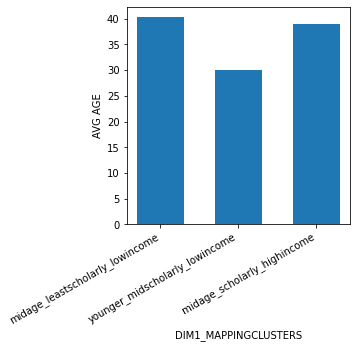

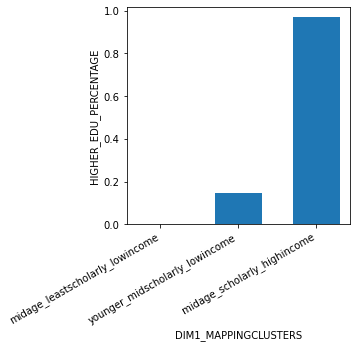

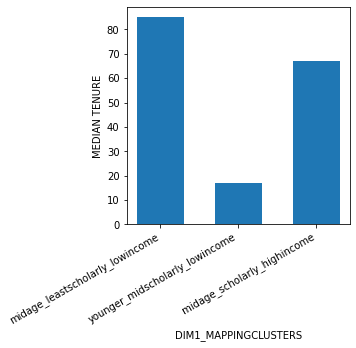

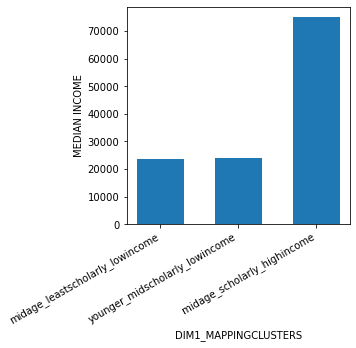

In [223]:
df_an2 = execute(query_gen("DIM1_CLUSTER", "DIM1_MAPPING"))
   
plotter("DIM1_MAPPING", "AVG(AGE)", "AVG AGE")   
plotter("DIM1_MAPPING", "HIGHER_EDU_PERCENTAGE", "HIGHER_EDU_PERCENTAGE")   
plotter("DIM1_MAPPING", "MEDIAN(TENURE)", "MEDIAN TENURE")  
plotter("DIM1_MAPPING", "MEDIAN(INCOME)", "MEDIAN INCOME")  

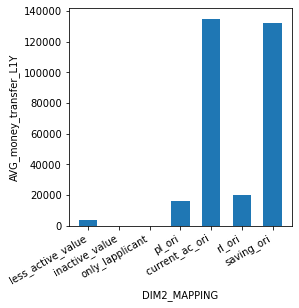

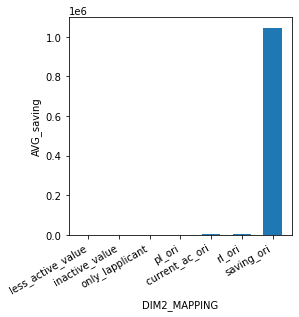

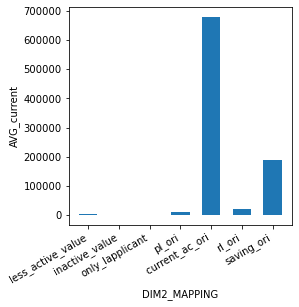

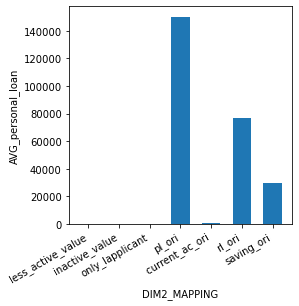

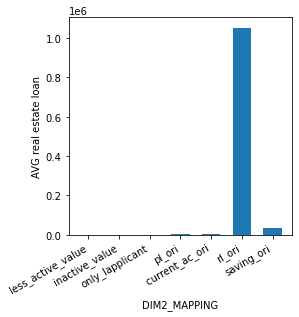

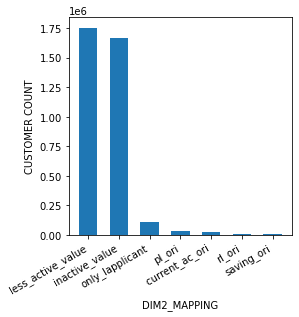

In [185]:
df_an2 = execute(query_gen("DIM3_CLUSTER", "DIM3_MAPPING"))
plotter("DIM2_MAPPING", 'AVERAGE_MONEY_TRANSFER_L1Y', 'AVG_money_transfer_L1Y')  
plotter("DIM2_MAPPING", 'AVG_SAVING', 'Average Saving Account Balance ')  
plotter("DIM2_MAPPING", 'AVG_CURRENT', 'Average Current Account Balance')  
plotter("DIM2_MAPPING", 'AVG(TOTAL_FUNDING_AMOUNT_T313_15_16)', 'Avg. personal_loan funding amount')  
plotter("DIM2_MAPPING", 'AVG(TOTAL_FUNDING_AMOUNT_T314_17)', 'Avg. real estate funding amount')
plotter("DIM2_MAPPING", 'avg(NUMBER_OF_APPLICATIONS)', 'Number of Applications')  
plotter("DIM2_MAPPING", 'CNT', 'CUSTOMER COUNT')  


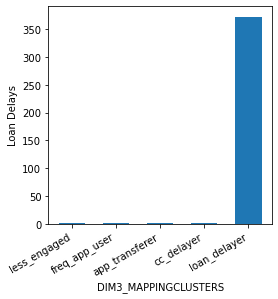

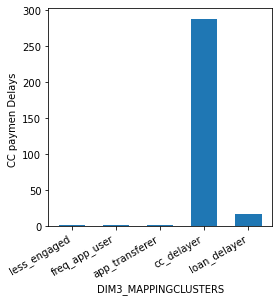

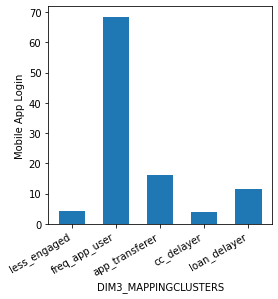

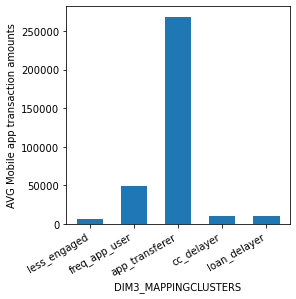

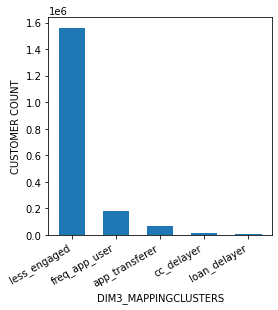

In [337]:
#df_an2 = execute(query_gen("DIM3_CLUSTER", "DIM3_MAPPING"))
#df_an2.drop(df_an2.query("DIM3_CLUSTER != DIM3_CLUSTER ").index, inplace=True)

plotter("DIM3_MAPPING", 'AVG(DELINQUENT_LOAN_INS_L5Y)', 'Loan Delays')  
plotter("DIM3_MAPPING", 'AVG(DELINQUENT_CC_INS_L5Y)', 'CC paymen Delays ')  
plotter("DIM3_MAPPING", 'AVG(MOBILE_APP_LOGIN_L3M)', 'Mobile App Login')  
plotter("DIM3_MAPPING", 'AVG_APP_TRANSACTION_AMOUNT_L3M', 'AVG Mobile app transaction amounts') 
plotter("DIM3_MAPPING", 'CNT', 'CUSTOMER COUNT') 


In [331]:
data_ = execute(query_gen("DIM1_CLUSTER", "DIM1_MAPPING"))
print(data_.head())
project.save_data(file_name="DATA_DIM1.csv", data=data_.to_csv(), set_project_asset=True,  overwrite=True) 

data_ = execute(query_gen("DIM2_CLUSTER", "DIM2_MAPPING"))
print(data_.head())
project.save_data(file_name="DATA_DIM2.csv", data=data_.to_csv(), set_project_asset=True,  overwrite=True) 

data_ = execute(query_gen("DIM3_CLUSTER", "DIM3_MAPPING"))
print(data_.head())
project.save_data(file_name="DATA_DIM3.csv", data=data_.to_csv(), set_project_asset=True,  overwrite=True) 



  DIM1_CLUSTER                     DIM1_MAPPING      CNT             AVG(AGE)  \
0         d1_2  midage_leastscholarly_lowincome  1351448                40.30   
1         d1_3   younger_midscholarly_lowincome  1292715                30.02   
2         d1_1      midage_scholarly_highincome   950013                39.08   

   MEDIAN(AGE)          AVG(TENURE)  MEDIAN(TENURE)  HIGHER_EDU_PERCENTAGE  \
0           38                85.27              85                   0.00   
1           29                22.37              17                   0.14   
2           37                70.06              67                   0.97   

           AVG(INCOME)  MEDIAN(INCOME)  ...  MEDIAN(MOBILE_APP_LOGIN_L3M)  \
0            71,373.86           23520  ...                             0   
1       168,895,218.03           24000  ...                             0   
2           581,401.04           75000  ...                             0   

   AVG(DELINQUENT_LOAN_INS_L5Y)  MEDIAN(DELINQUENT_LO

{'file_name': 'DATA_DIM3.csv',
 'message': 'File saved to project storage.',
 'asset_id': '78f4f9ec-05ed-47df-8339-771a9ace5a8b'}

In [329]:
project.save_data(file_name="df_an1_1220.csv", data=df_an1.to_csv(), set_project_asset=True,  overwrite=True) 

{'file_name': 'df_an1_1220.csv',
 'message': 'File saved to project storage.',
 'asset_id': '8bef57f5-3884-4e08-a0c6-ead286a3f5da'}

## Parallel Coordinates Vis

In [293]:
import plotly.express as px
#data = df_an2[["DIM3_CLUSTER", "AVG(DELINQUENT_LOAN_INS_L5Y)", 'AVG(DELINQUENT_CC_INS_L5Y)','AVG(MOBILE_APP_LOGIN_L3M)','AVG_APP_TRANSACTION_AMOUNT'  ]]
data["DIM3_CLUSTER"]= data["DIM3_CLUSTER"].map({"d3_1": 1, "d3_2":2, "d3_3":3, "d3_4":4, "d3_5":5})
fig = px.parallel_coordinates(data,   dimensions = [ "AVG(DELINQUENT_LOAN_INS_L5Y)", 'AVG(DELINQUENT_CC_INS_L5Y)','AVG(MOBILE_APP_LOGIN_L3M)','AVG_APP_TRANSACTION_AMOUNT'],
                     labels = ["DIM3_CLUSTER"], color = data["DIM3_CLUSTER"])
fig.show()

In [294]:
data_=df_p1
project.save_data(file_name="fig.html", data=fig.to_html(), set_project_asset=True,  overwrite=True) 


{'file_name': 'fig.html',
 'message': 'File saved to project storage.',
 'asset_id': '0bff88ff-d544-4f2d-aa5a-af95395da520'}